# `03-analysis`
In this notebook, we showcase the analysis techniques of the data.
Specifically, we show the different methods used to calculate breathing rate.

## Preliminaries
Imports

In [1]:
import scipy as sp
import pathlib
import pickle
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 600

import src.signals.breathing_rate as br

Define paths (based on the Cookiecutter file structure)

In [2]:
PATH_DATA = pathlib.Path('../data/processed')

## Read data
In this notebook, we will visualize one NN segment from one single participant
for demo purposes. I chose this as an example since it is a relatively
clean signal. However, feel free to experiment with data from different
participants and different segments! This should give you an idea of
the variability between the signals and how this affects the performance
of the different methods.

The script `calculate_breathing_rate` (`calculate_breathing_rate` in 
the `Makefile`) processes the whole dataset.

In [3]:
participant_id = 'f2y10'
with open(str(PATH_DATA/(participant_id + '.pkl')), 'rb') as f:
    dataset = pickle.load(f)

nn = dataset['nn_interp_y_trimmed_3'][30]
fs = 1/dataset['T_int']  # Remember that the NN signal was interpolated with interval T_int.

## Calculate breathing rate
For each method, I provide a short summary. 
See the script [`breathing_rate.py`](../src/signals/breathing_rate.py) for a 
more detailed description and their corresponding implementation.

We will store the computed breathing rates in a dictionary.

In [4]:
breathing_rate = {}

### Spectral analysis
These methods are based on spectral analysis and looking for prominent
components in the 0.1 - 0.5 Hz band.

#### Fourier analysis (`Spec-FT`)
In this method (originally proposed by Heckmann and Schenk), the frequency
of the absolute maximum $|Xm|$ in the 0.1 - 0.5 Hz band is interepreted as the
mean respiratory rate. However, two conditions need to be fulfilled:
* The maximum component $|Xm|$ should be larger than the mean +/- 1 SD of the
entire spectrum
* The difference between $|Xm|$ and the second largest component should be >=10% of $|Xm|$

    or

    The frequency of $|Xm|$ should be separated from the frequency of the absolute maximum by <0.01 Hz.

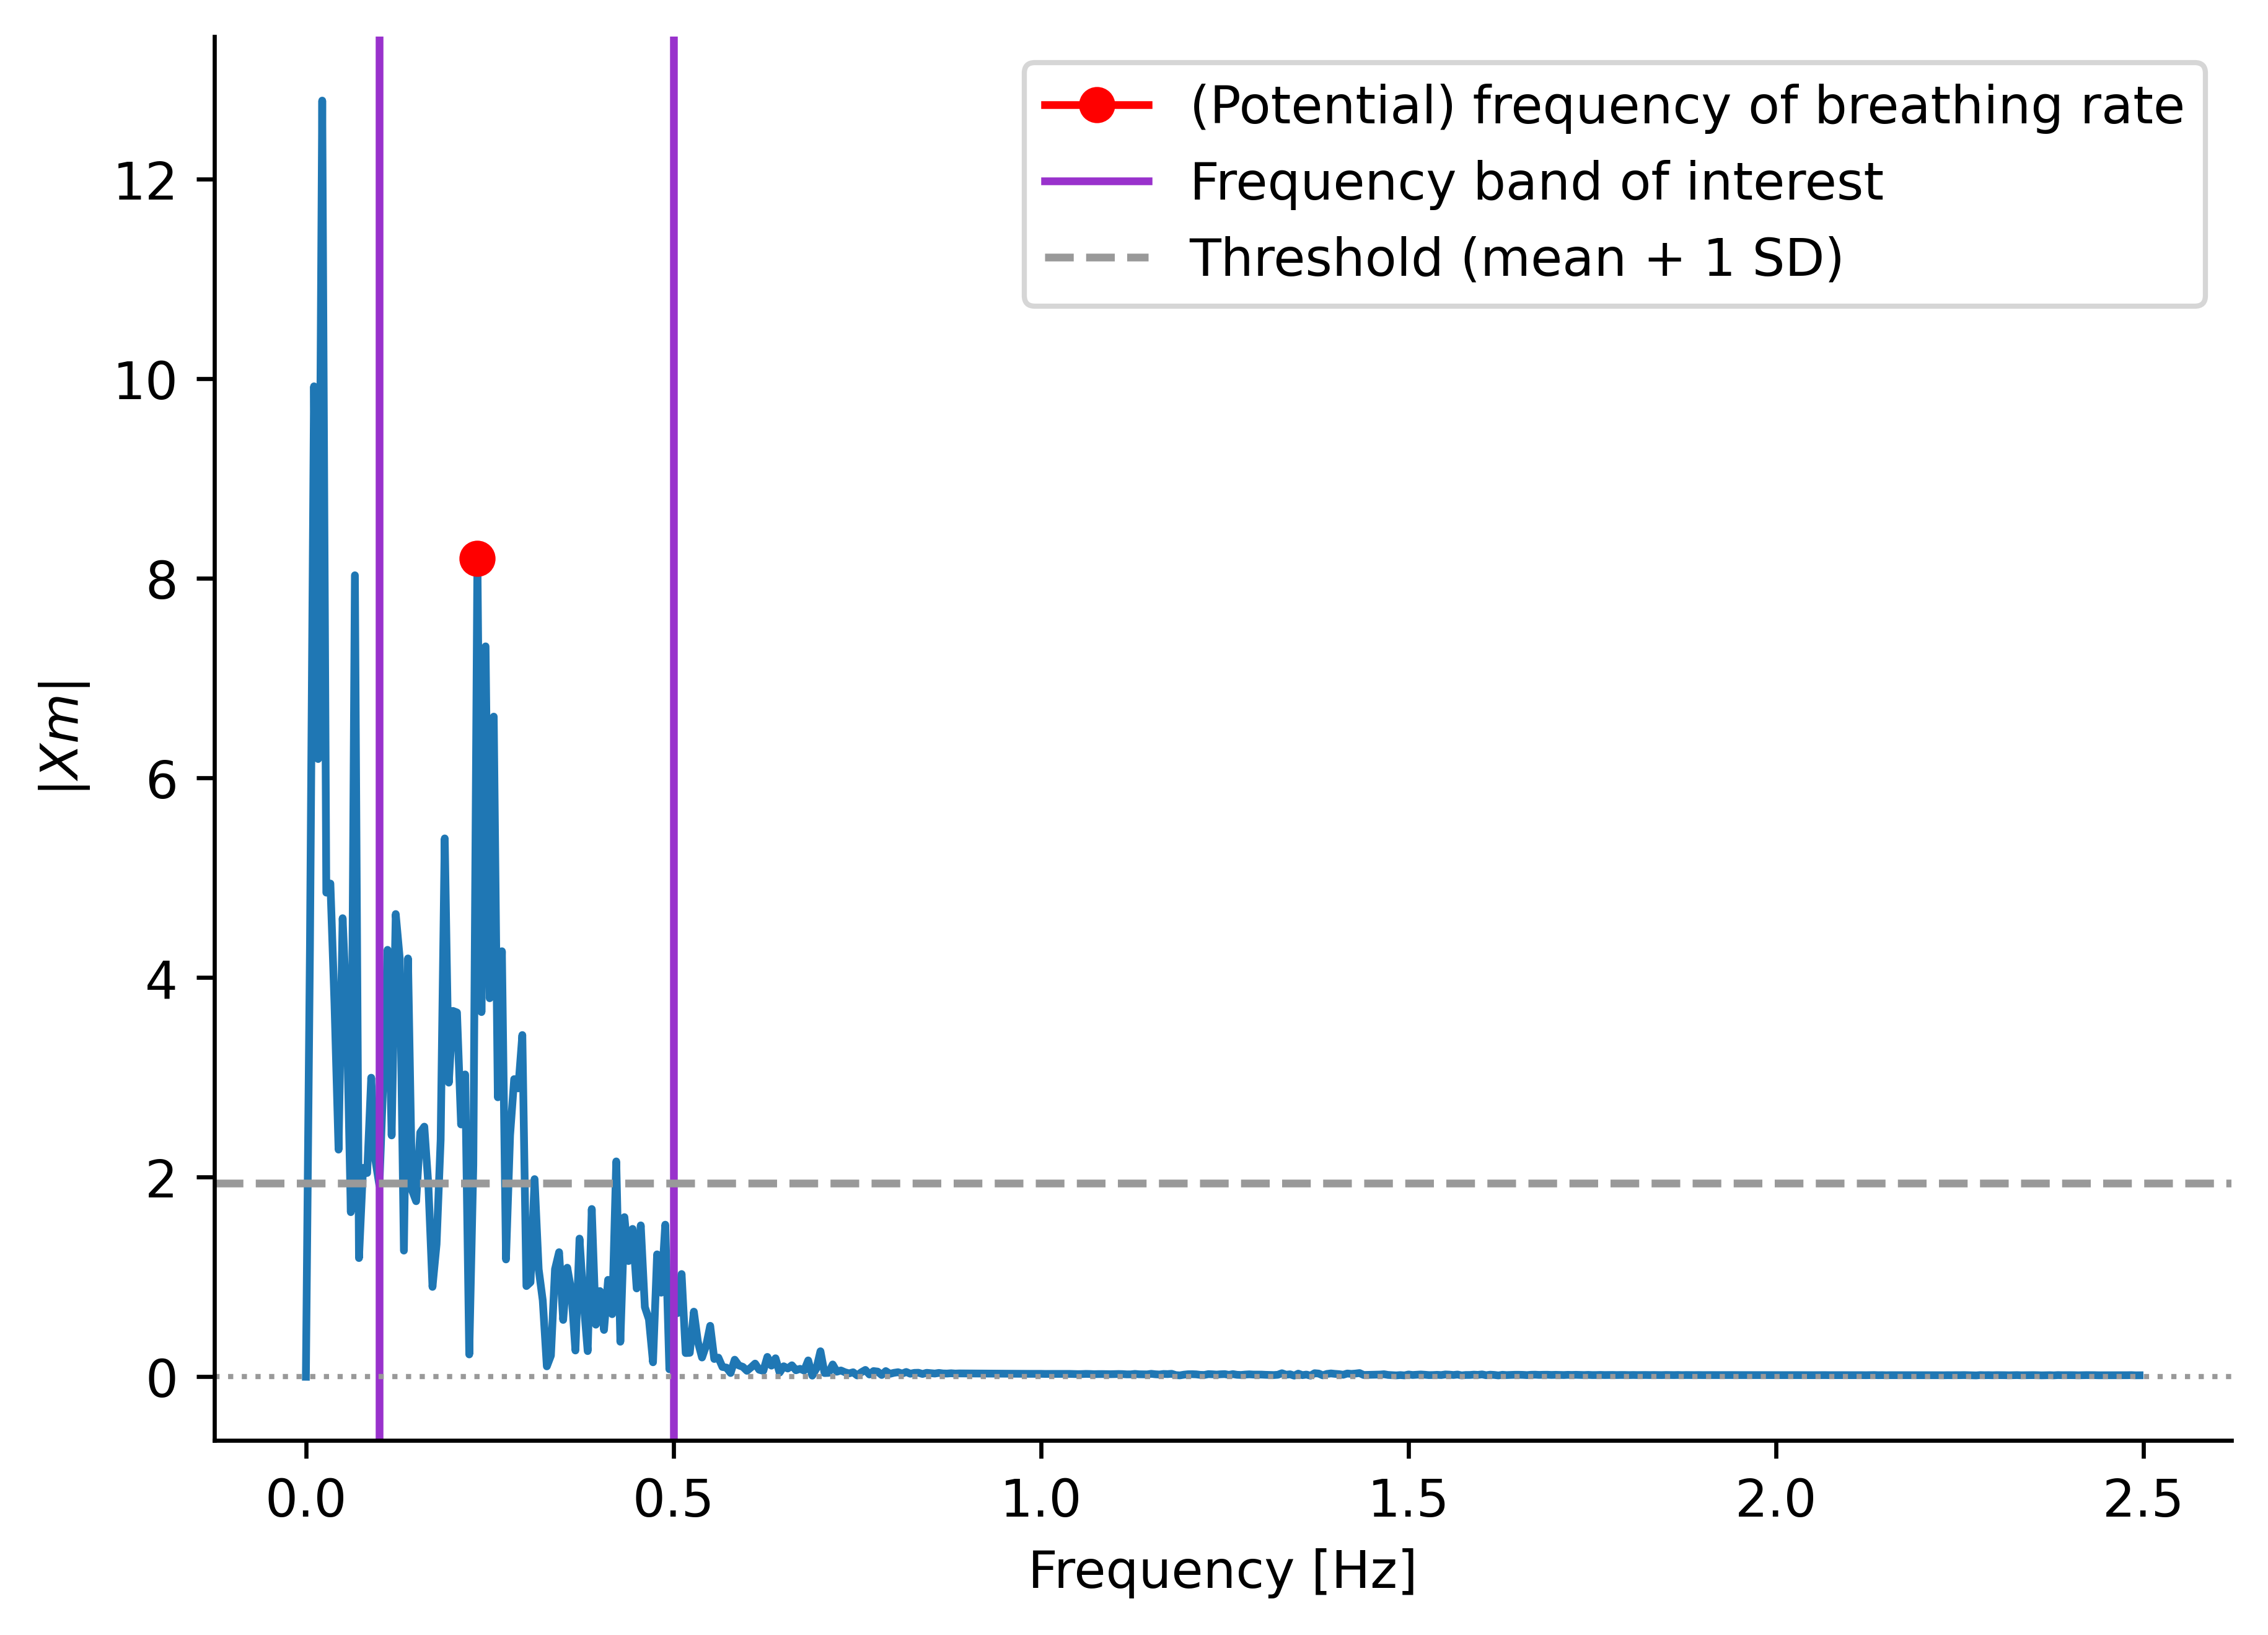

0.23333333333333334

In [5]:
breathing_rate['spec_ft'], fix, ax = br.spec_ft(nn, fs, f_low=0.1, f_high=0.5, visualizations=True)
breathing_rate['spec_ft']

#### Autoregressive modelling (`Spec-AR`)
This method (originally proposed by Fruhwirth) uses an autoregressive model 
to obtain the powed spectrum density (PSD) using a Burg algorithm with a 
model of order 15. If there is at least one frequency component in the
0.1 - 0.5 Hz band with a spectral power of >=5.5% of the total power, 
this component is defined as the breathing rate.

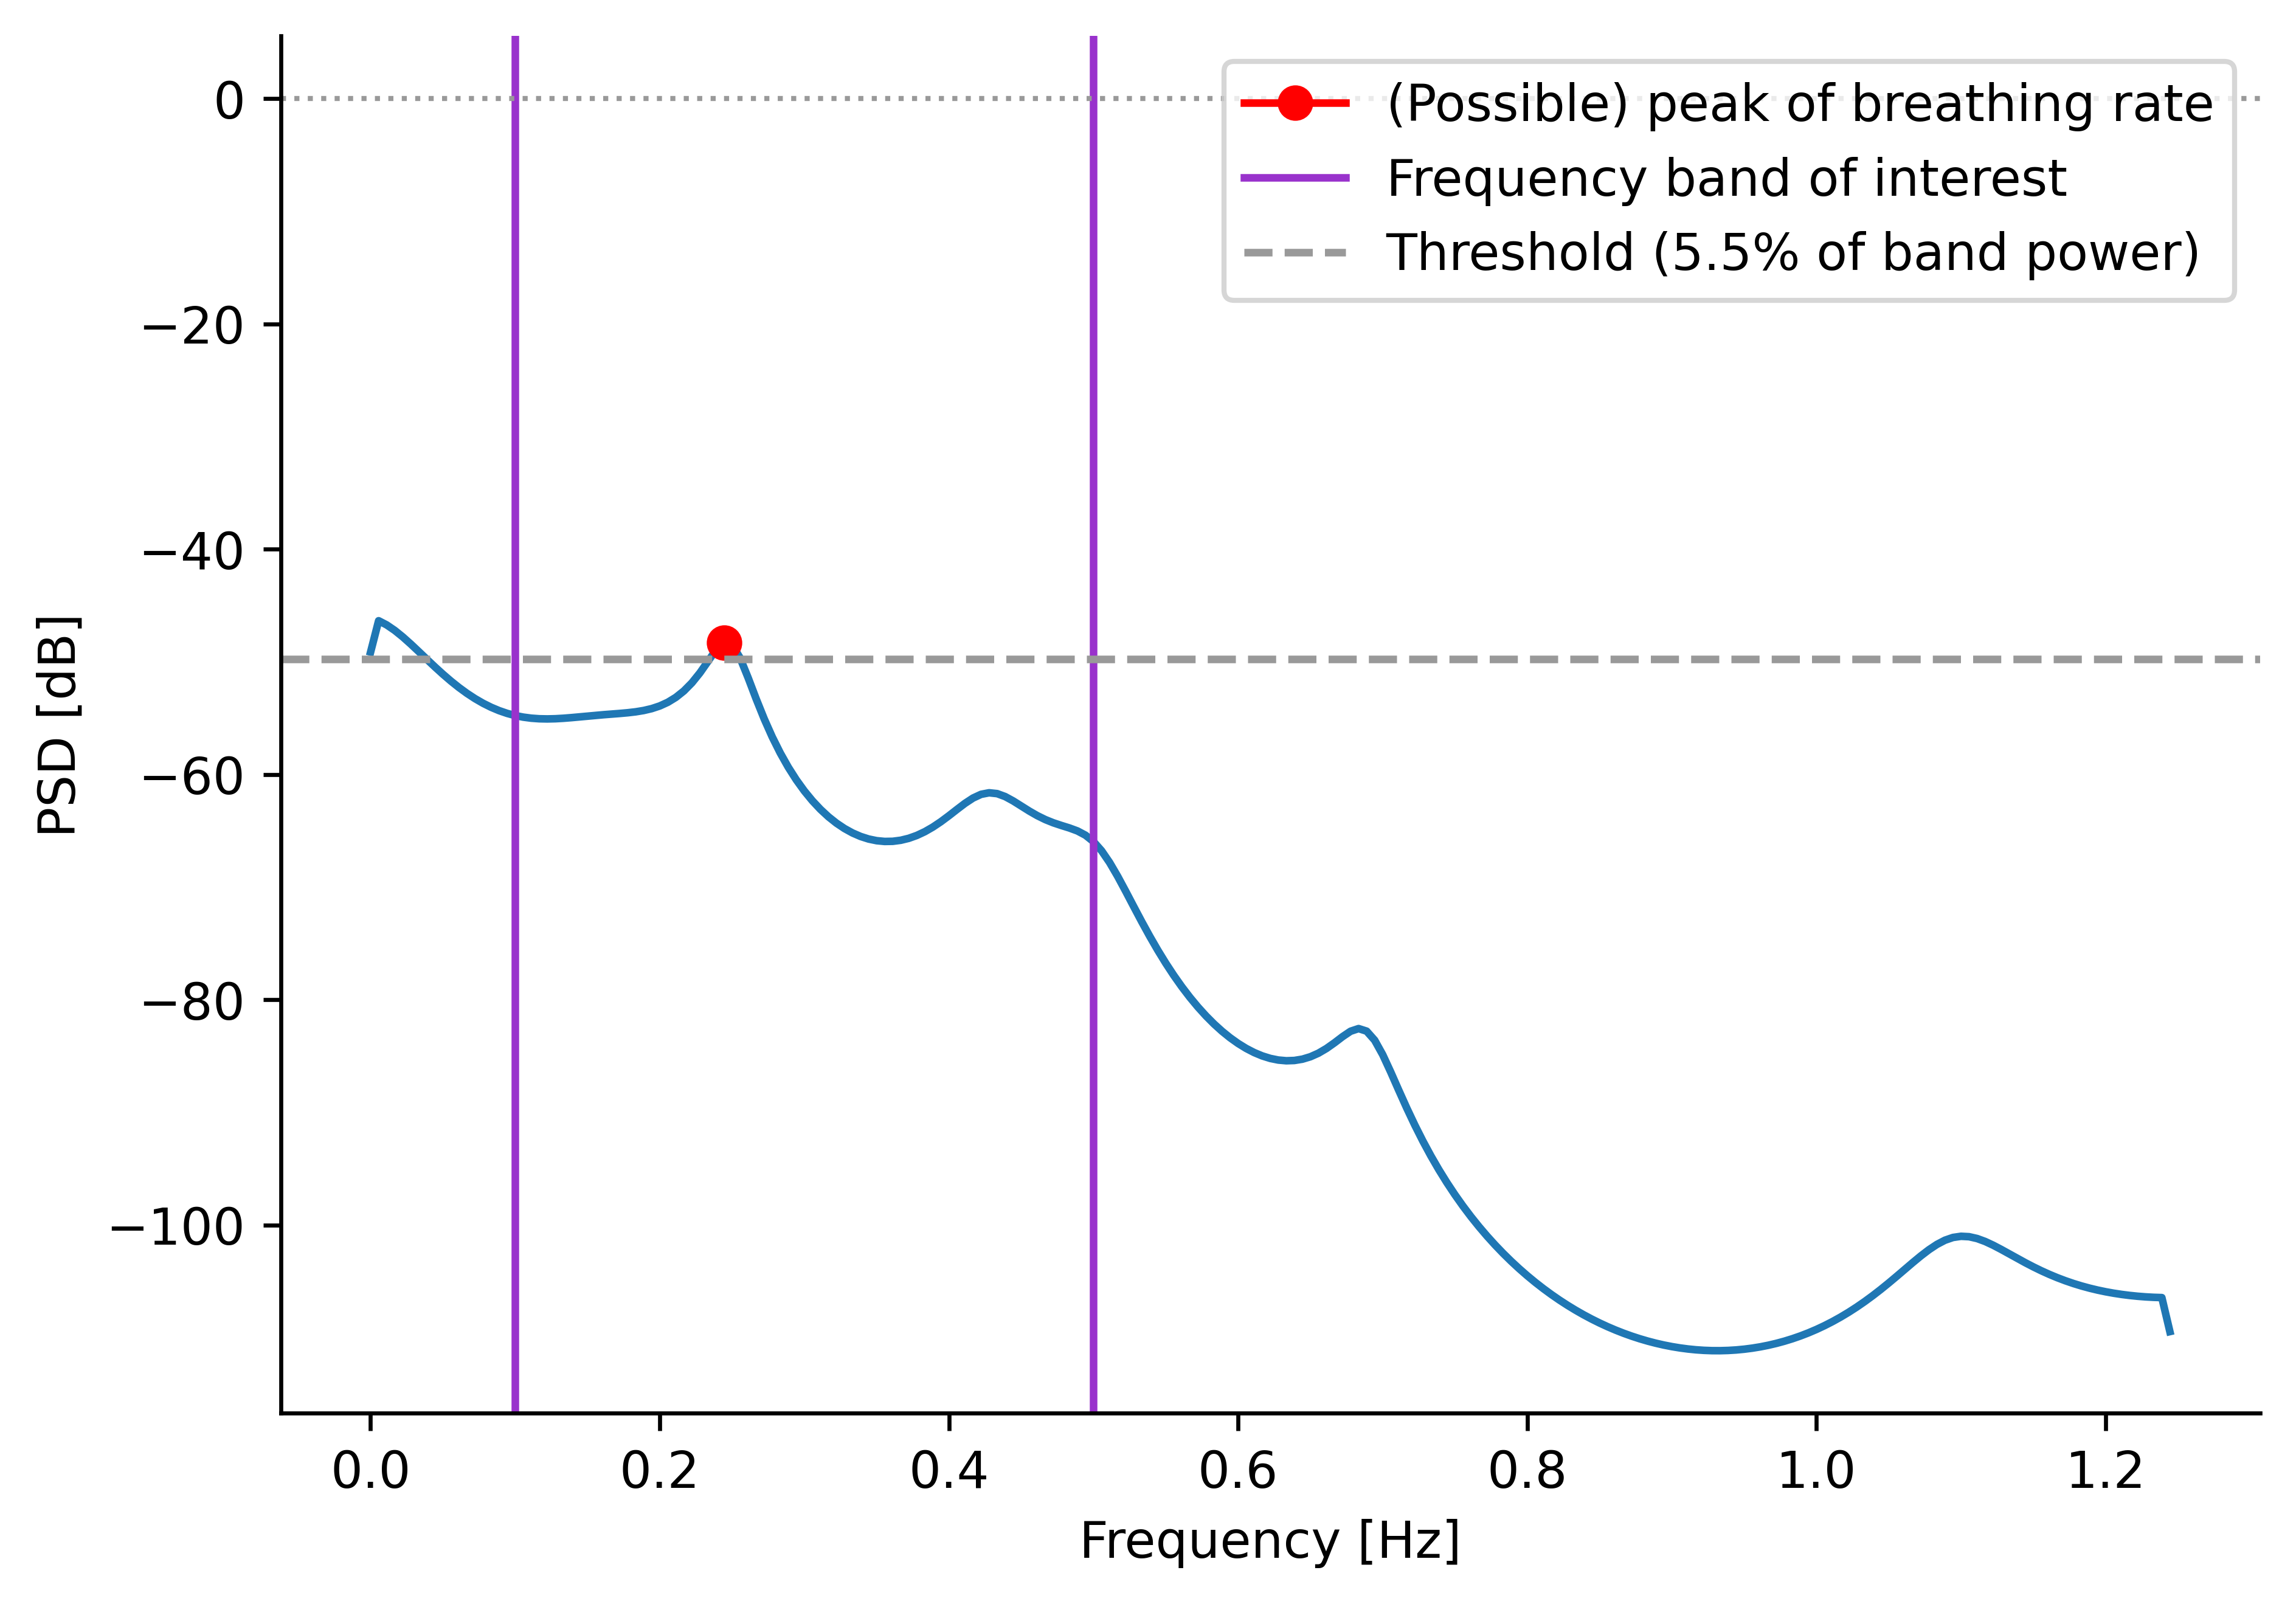

0.24444444444444446

In [6]:
breathing_rate['spec_ar'], fig, ax = br.spec_ar(nn, fs, f_low=0.1, f_high=0.5, visualizations=True)
breathing_rate['spec_ar']

### Autocorrelation function (ACF)
These methods are based on the ACF given by:

$\mathrm{ACF}_z(\delta) = \sum_{i=1}^{n-|\delta|} (z_i - \bar{z})(z_{i+|\delta|} - \bar{z})$

#### Autocorrelation maximum method (`ACF-max`)
This is a straightforward method: assuming respiration is periodic, 
its rate is given by the lag $\delta_{max}$ of the first positive maximum
of the ACF.

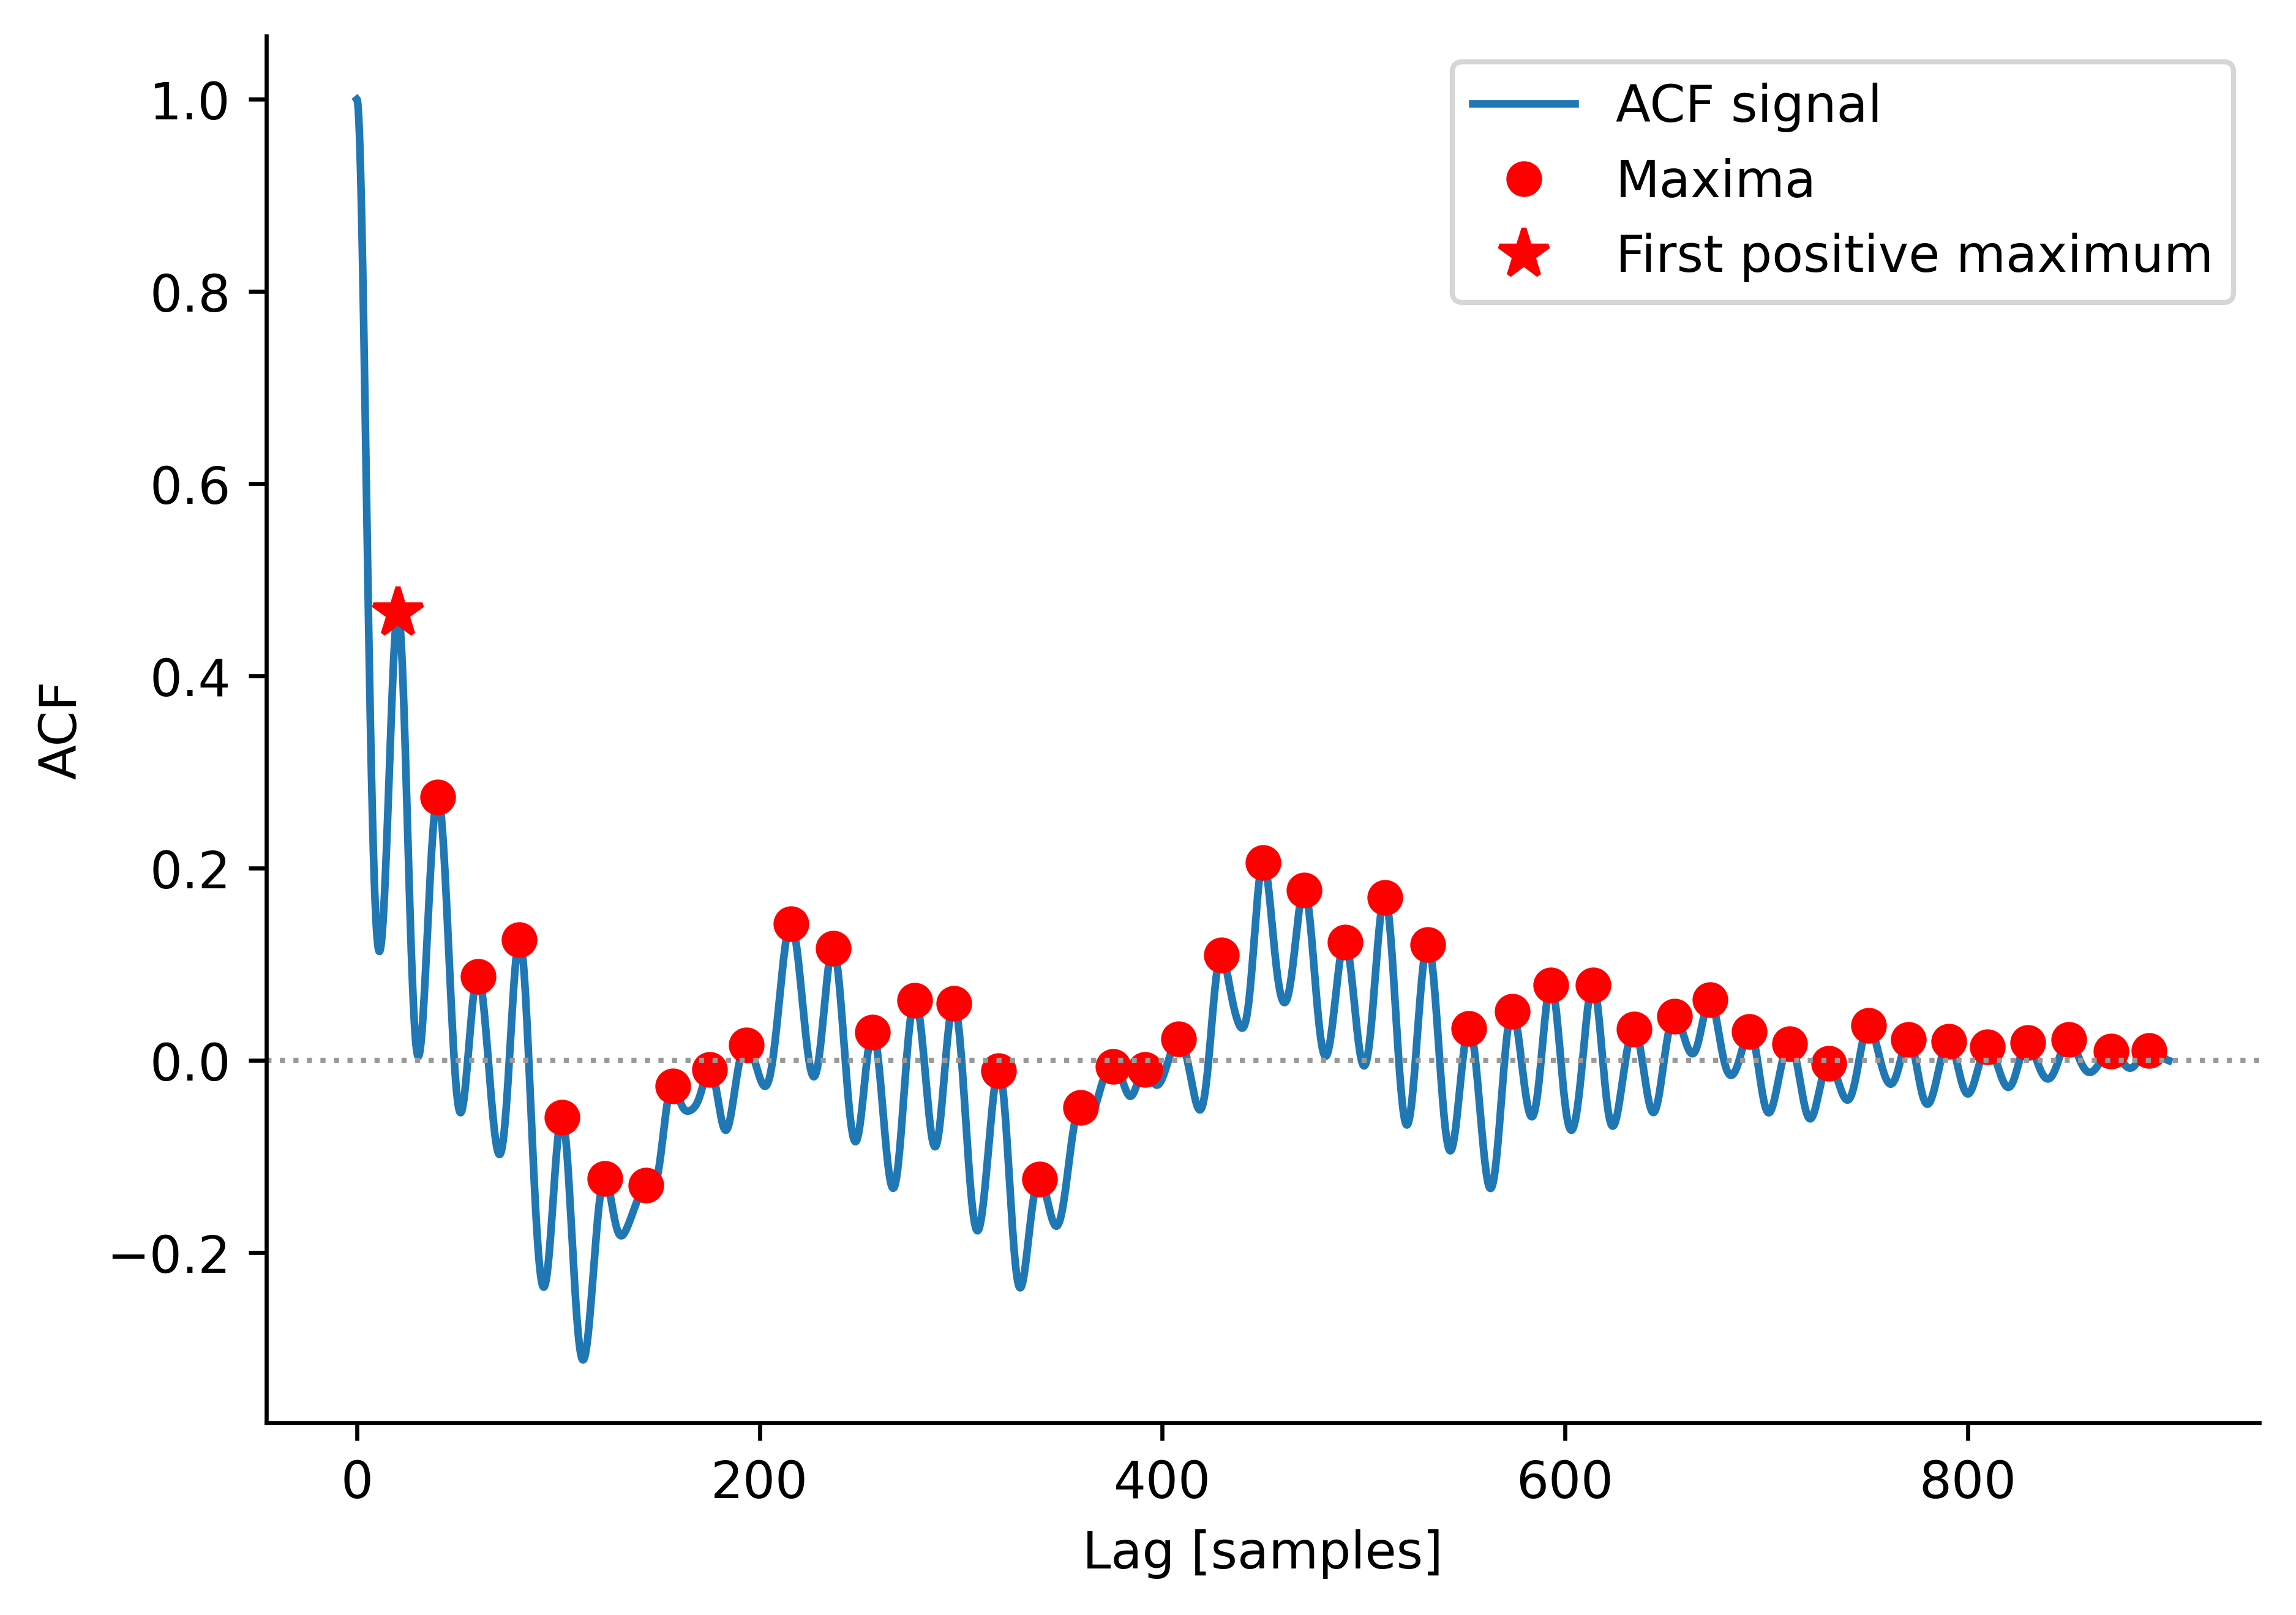

0.24509803921568626

In [7]:
breathing_rate['acf_max'], fig, ax = br.acf_max(nn, fs, f_low=0.1, f_high=0.5, visualizations=True)
breathing_rate['acf_max']

#### Autocorrelation advanced method (`ACF-adv`)
In this case, the NN signal is differentiated. Then, its ACF is computed
followed by its FFT. From its power spectrum, the median of all 
components of the 0.1 - 0.5 Hz band is calculated. The weighted
average of all components above this threshold in said band is taken
as the mean breathing rate.

d:\users\artur\documents\projects\breathing-rate-rsa\src\signals\breathing_rate.py:409: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 10*np.log10(psd), label="PSD")


0.25729634265300916

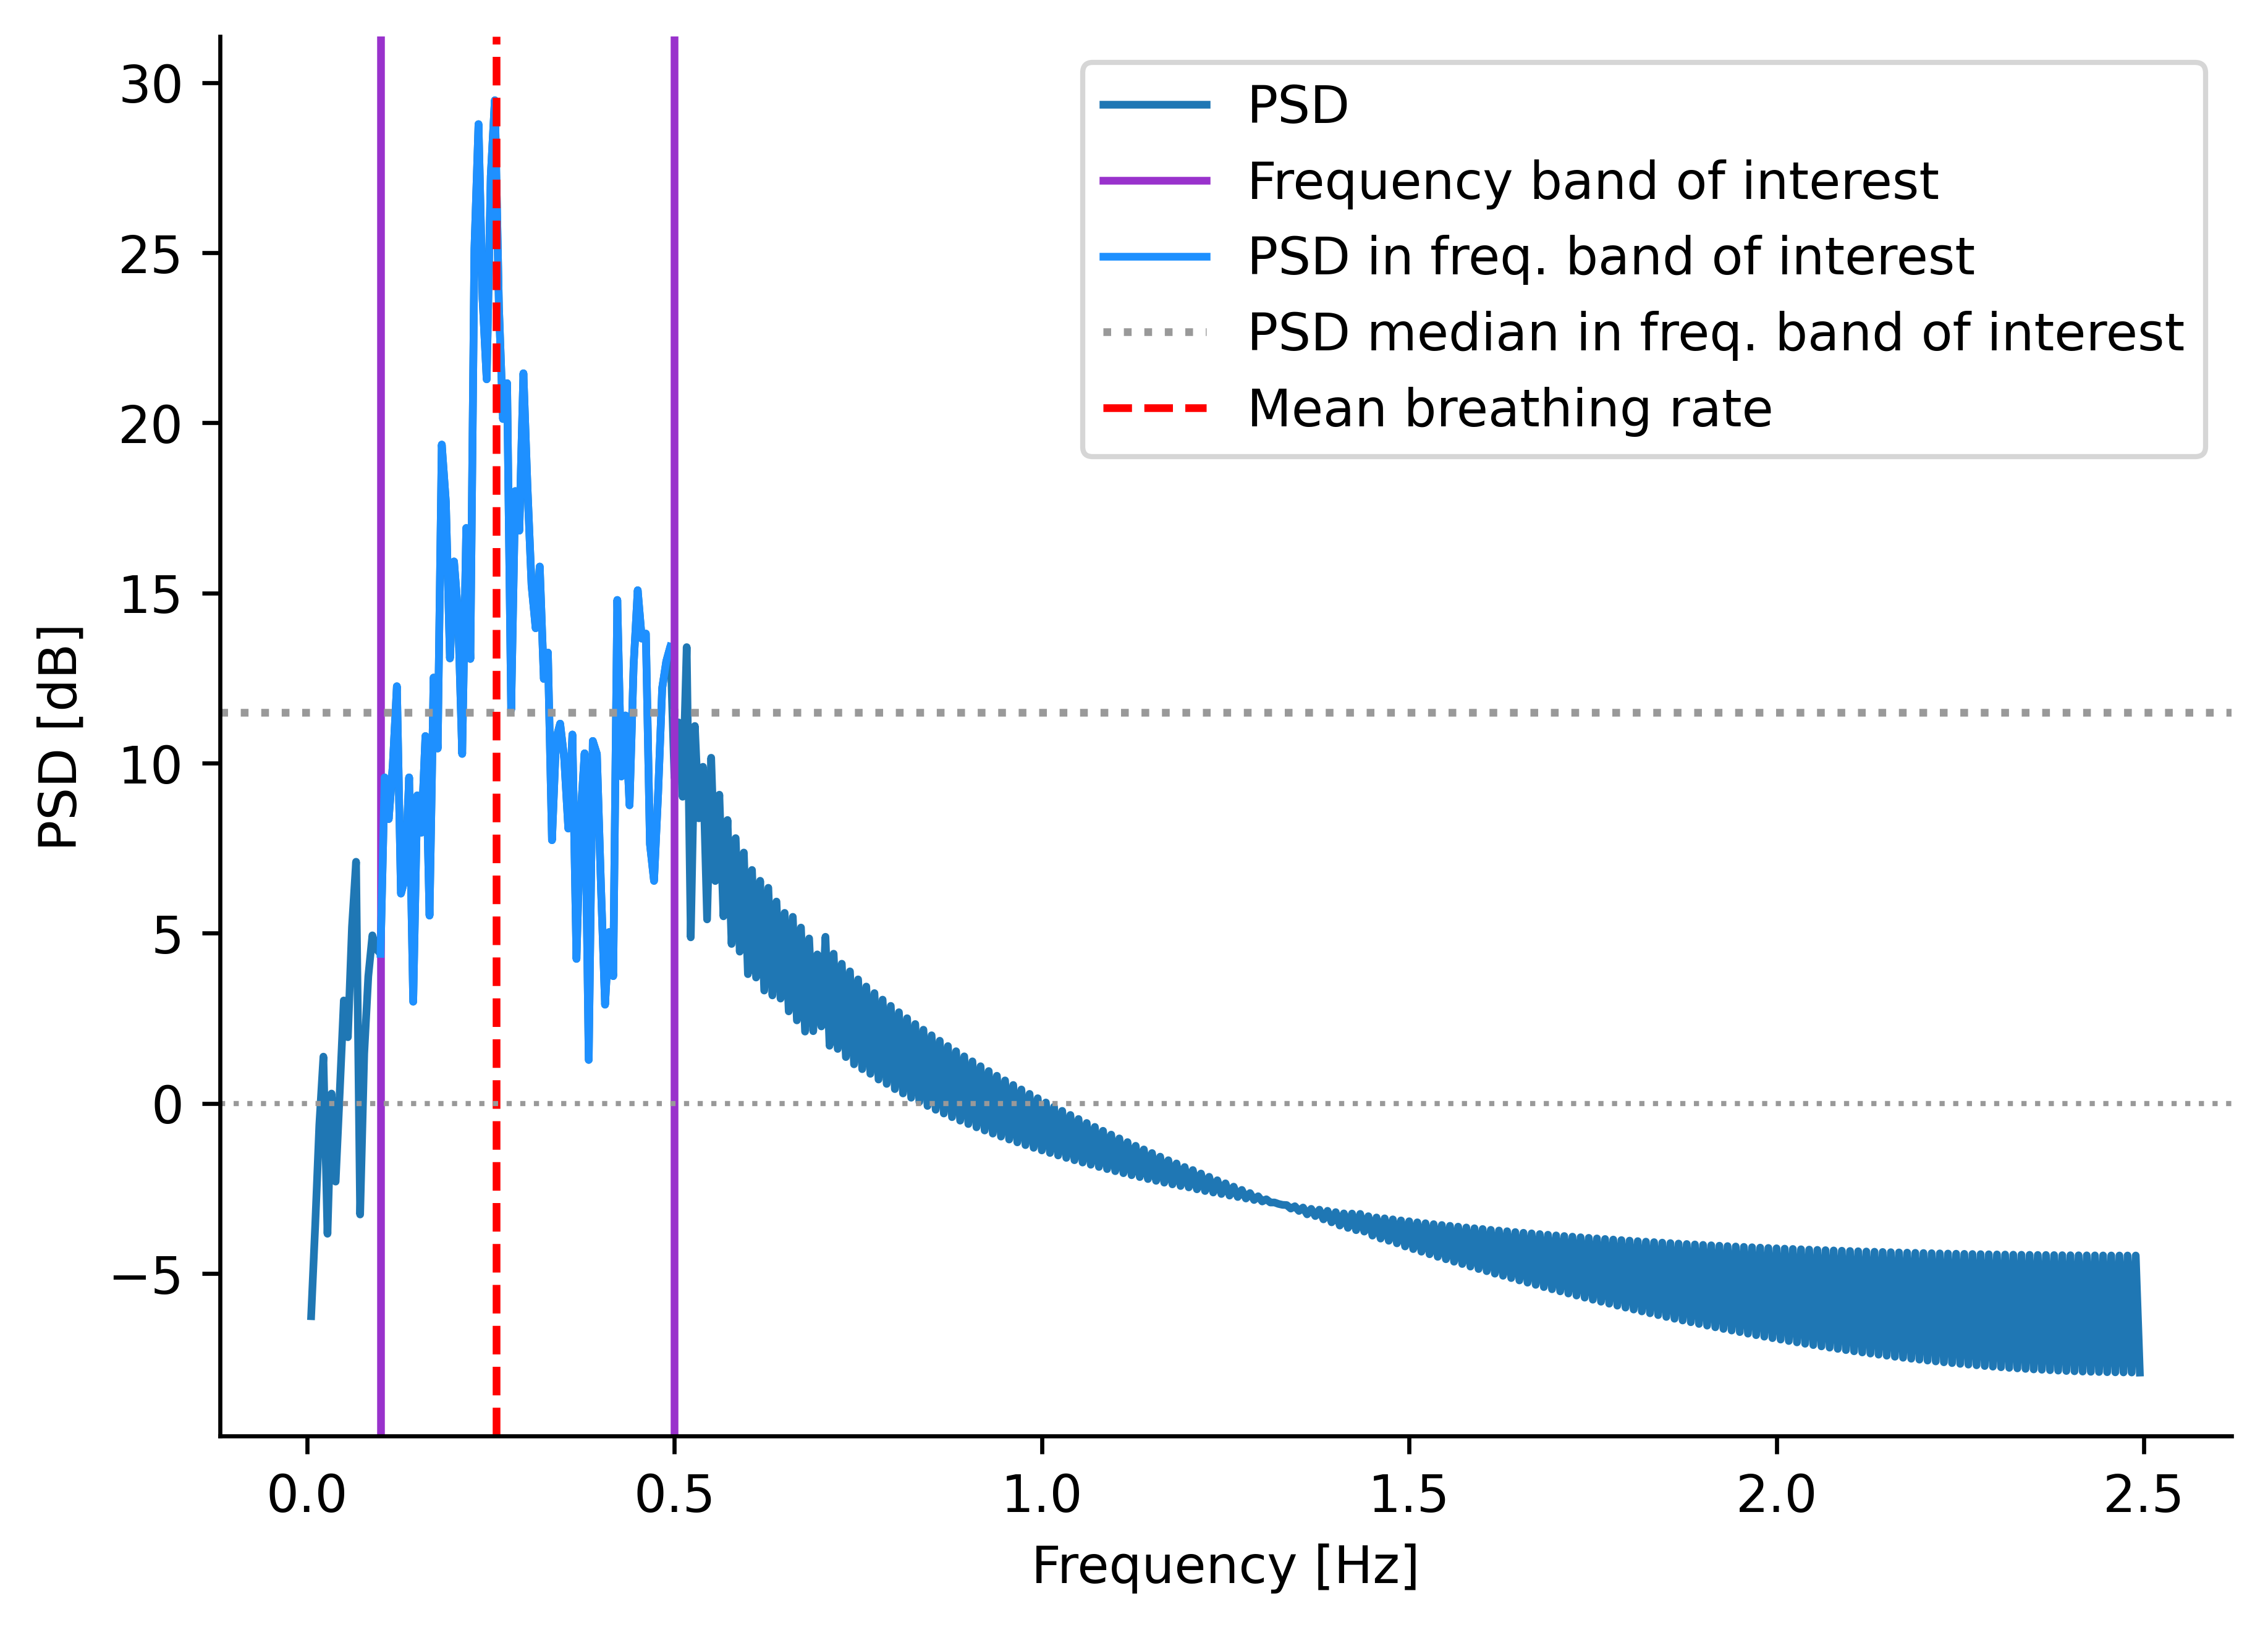

In [8]:
breathing_rate['acf_adv'], fig, ax = br.acf_adv(nn, fs, f_low=0.1, f_high=0.5, visualizations=True)
breathing_rate['acf_adv']

### Counting methods
These methods are based on counting prominent oscillations originating from
respiratory activity.

Both of the counting methods process the signal using a Butterworth 
BPF filter (step 1). This is how the filter is generated:

In [9]:
f_low = 0.1 # [Hz]
f_high = 0.5 # [Hz]

b, a = sp.signal.butter(6, [f_low, f_high], btype='bandpass', analog=False, fs=fs)
w, h = sp.signal.freqz(b, a, fs=fs)

nn_filtered = sp.signal.filtfilt(b, a, nn)

For the sake of completion, this is how the filter looks like:

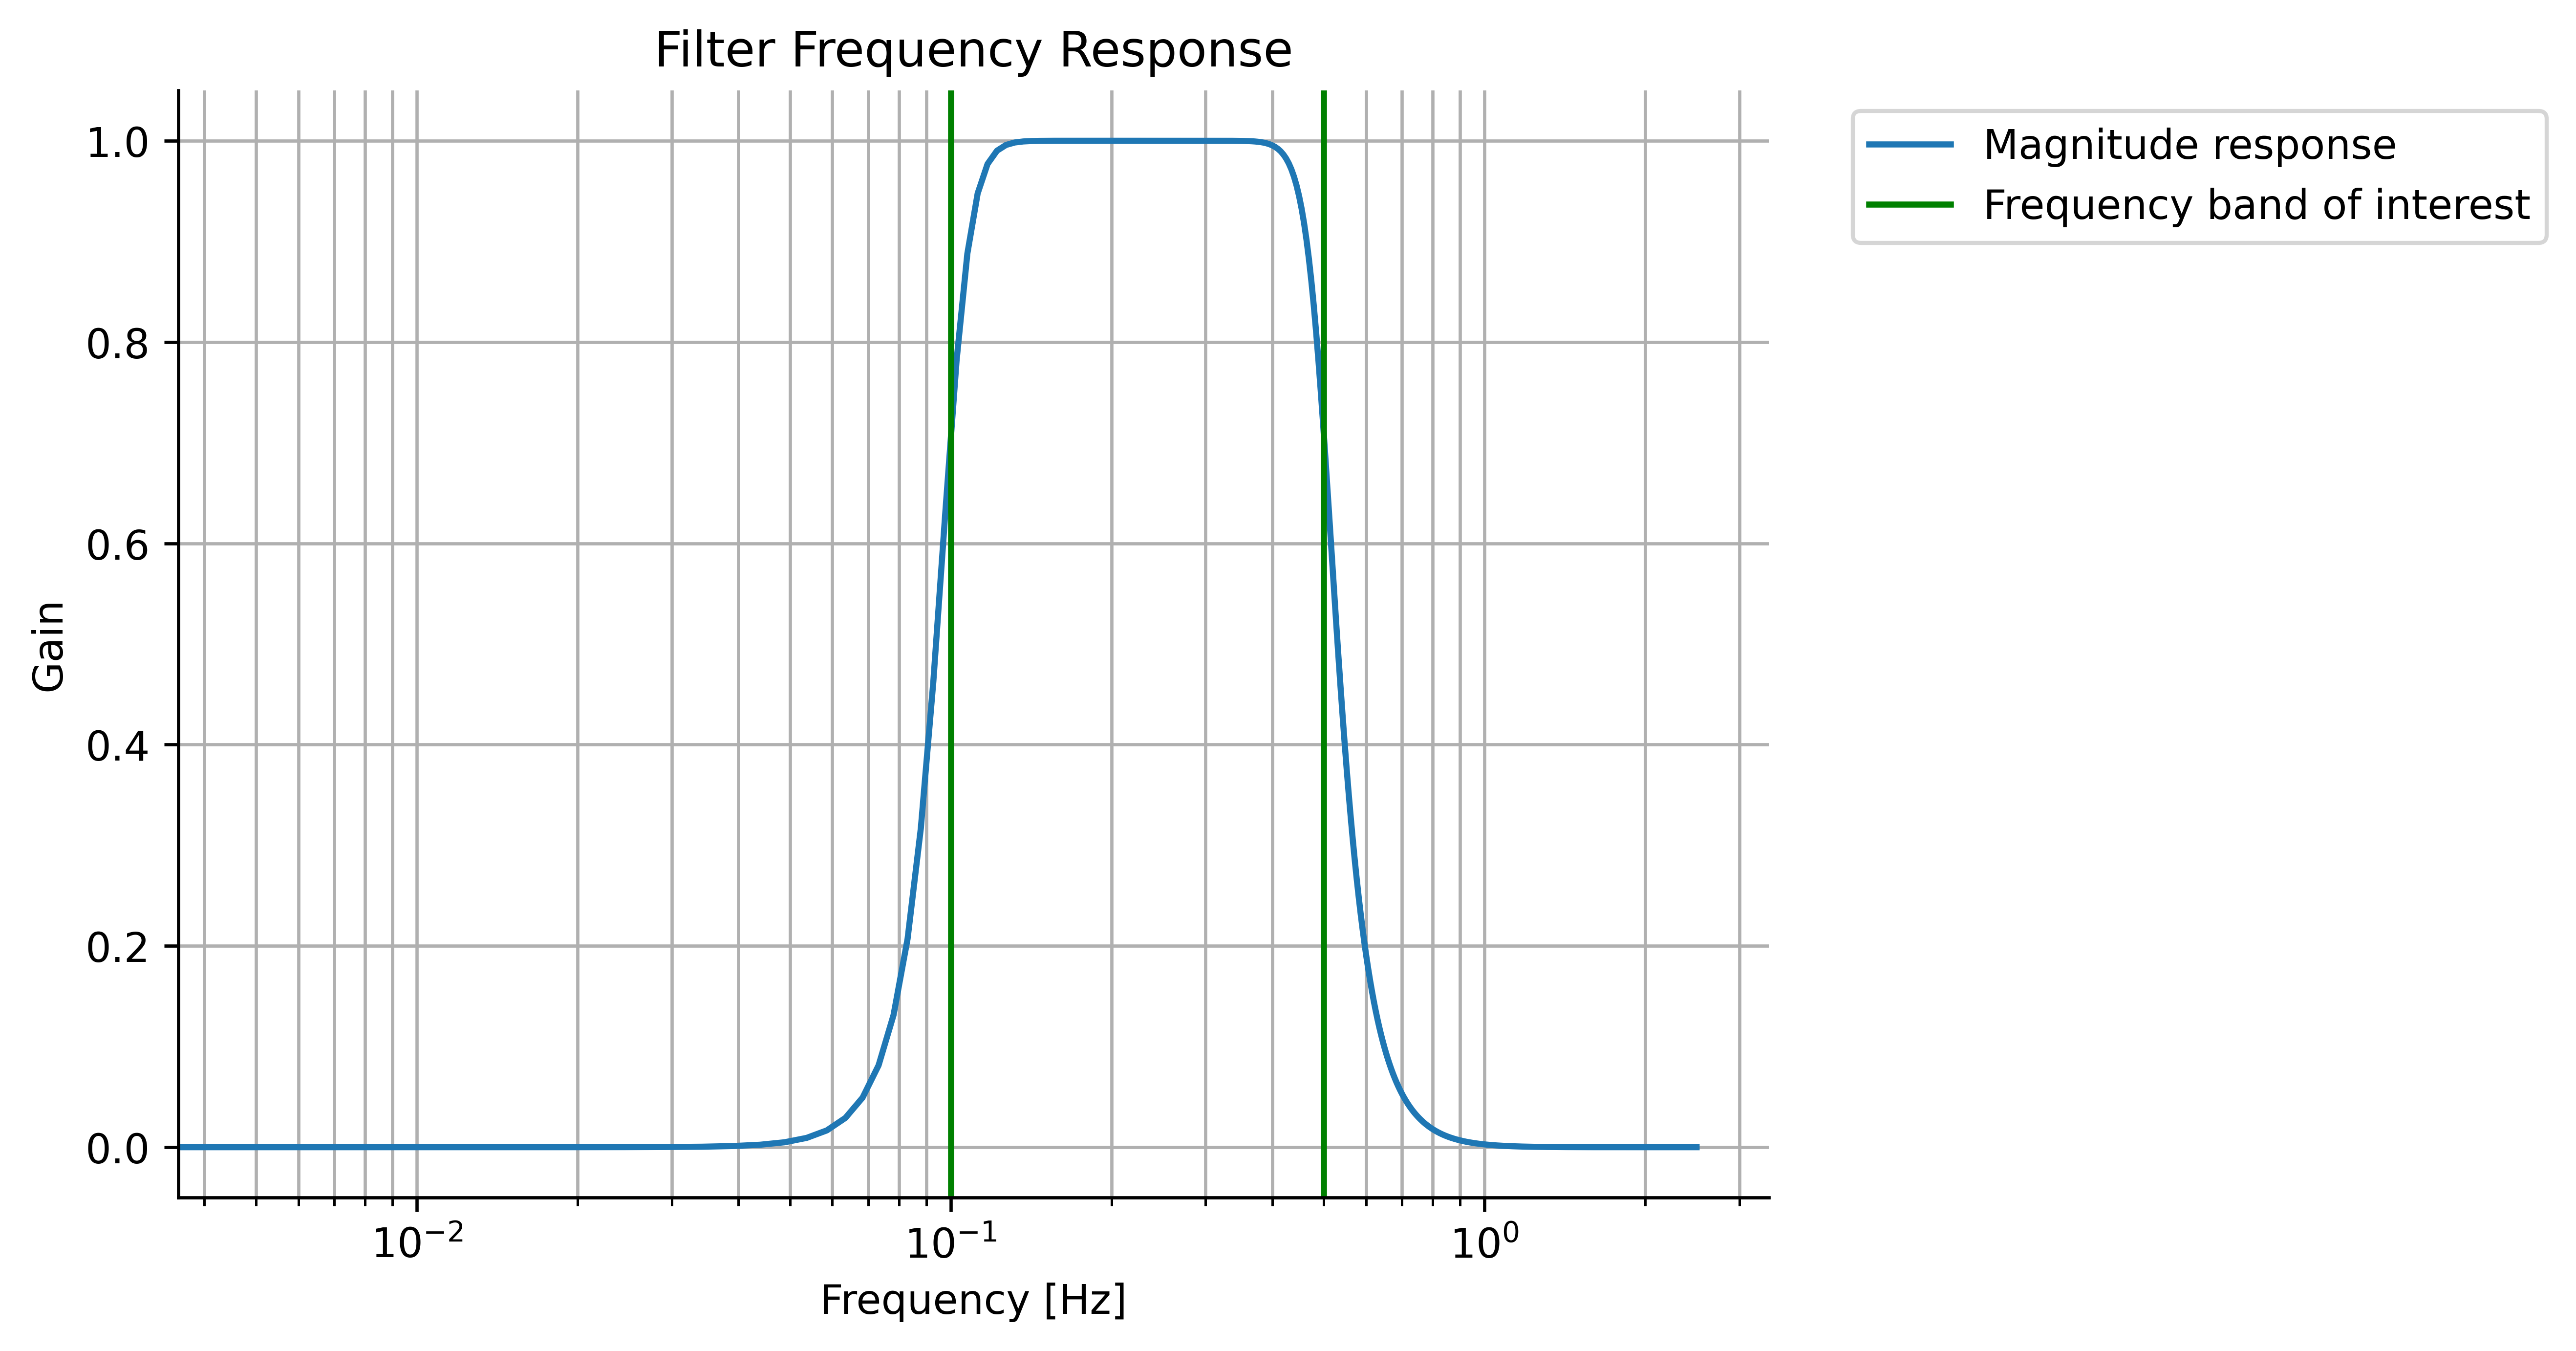

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[7,5])
plt.semilogx(w, abs(h), label="Magnitude response")
plt.grid(which='both', axis='both')
plt.axvline(f_low, color='green', label="Frequency band of interest")
plt.axvline(f_high, color='green')
plt.title('Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    
plt.show()

Notice that the original paper uses a 10th order filter.
However, we use `filtfilt` to filter the signal (to avoid distortion),
which would result in passing the signal through two 5th order filters.
Since we are using a BPF (LPF + HPF), a 5th order would result asymmetrical.
Thus, we opted to use a 12th order filter.

This is how the original and the filtered signal look like.

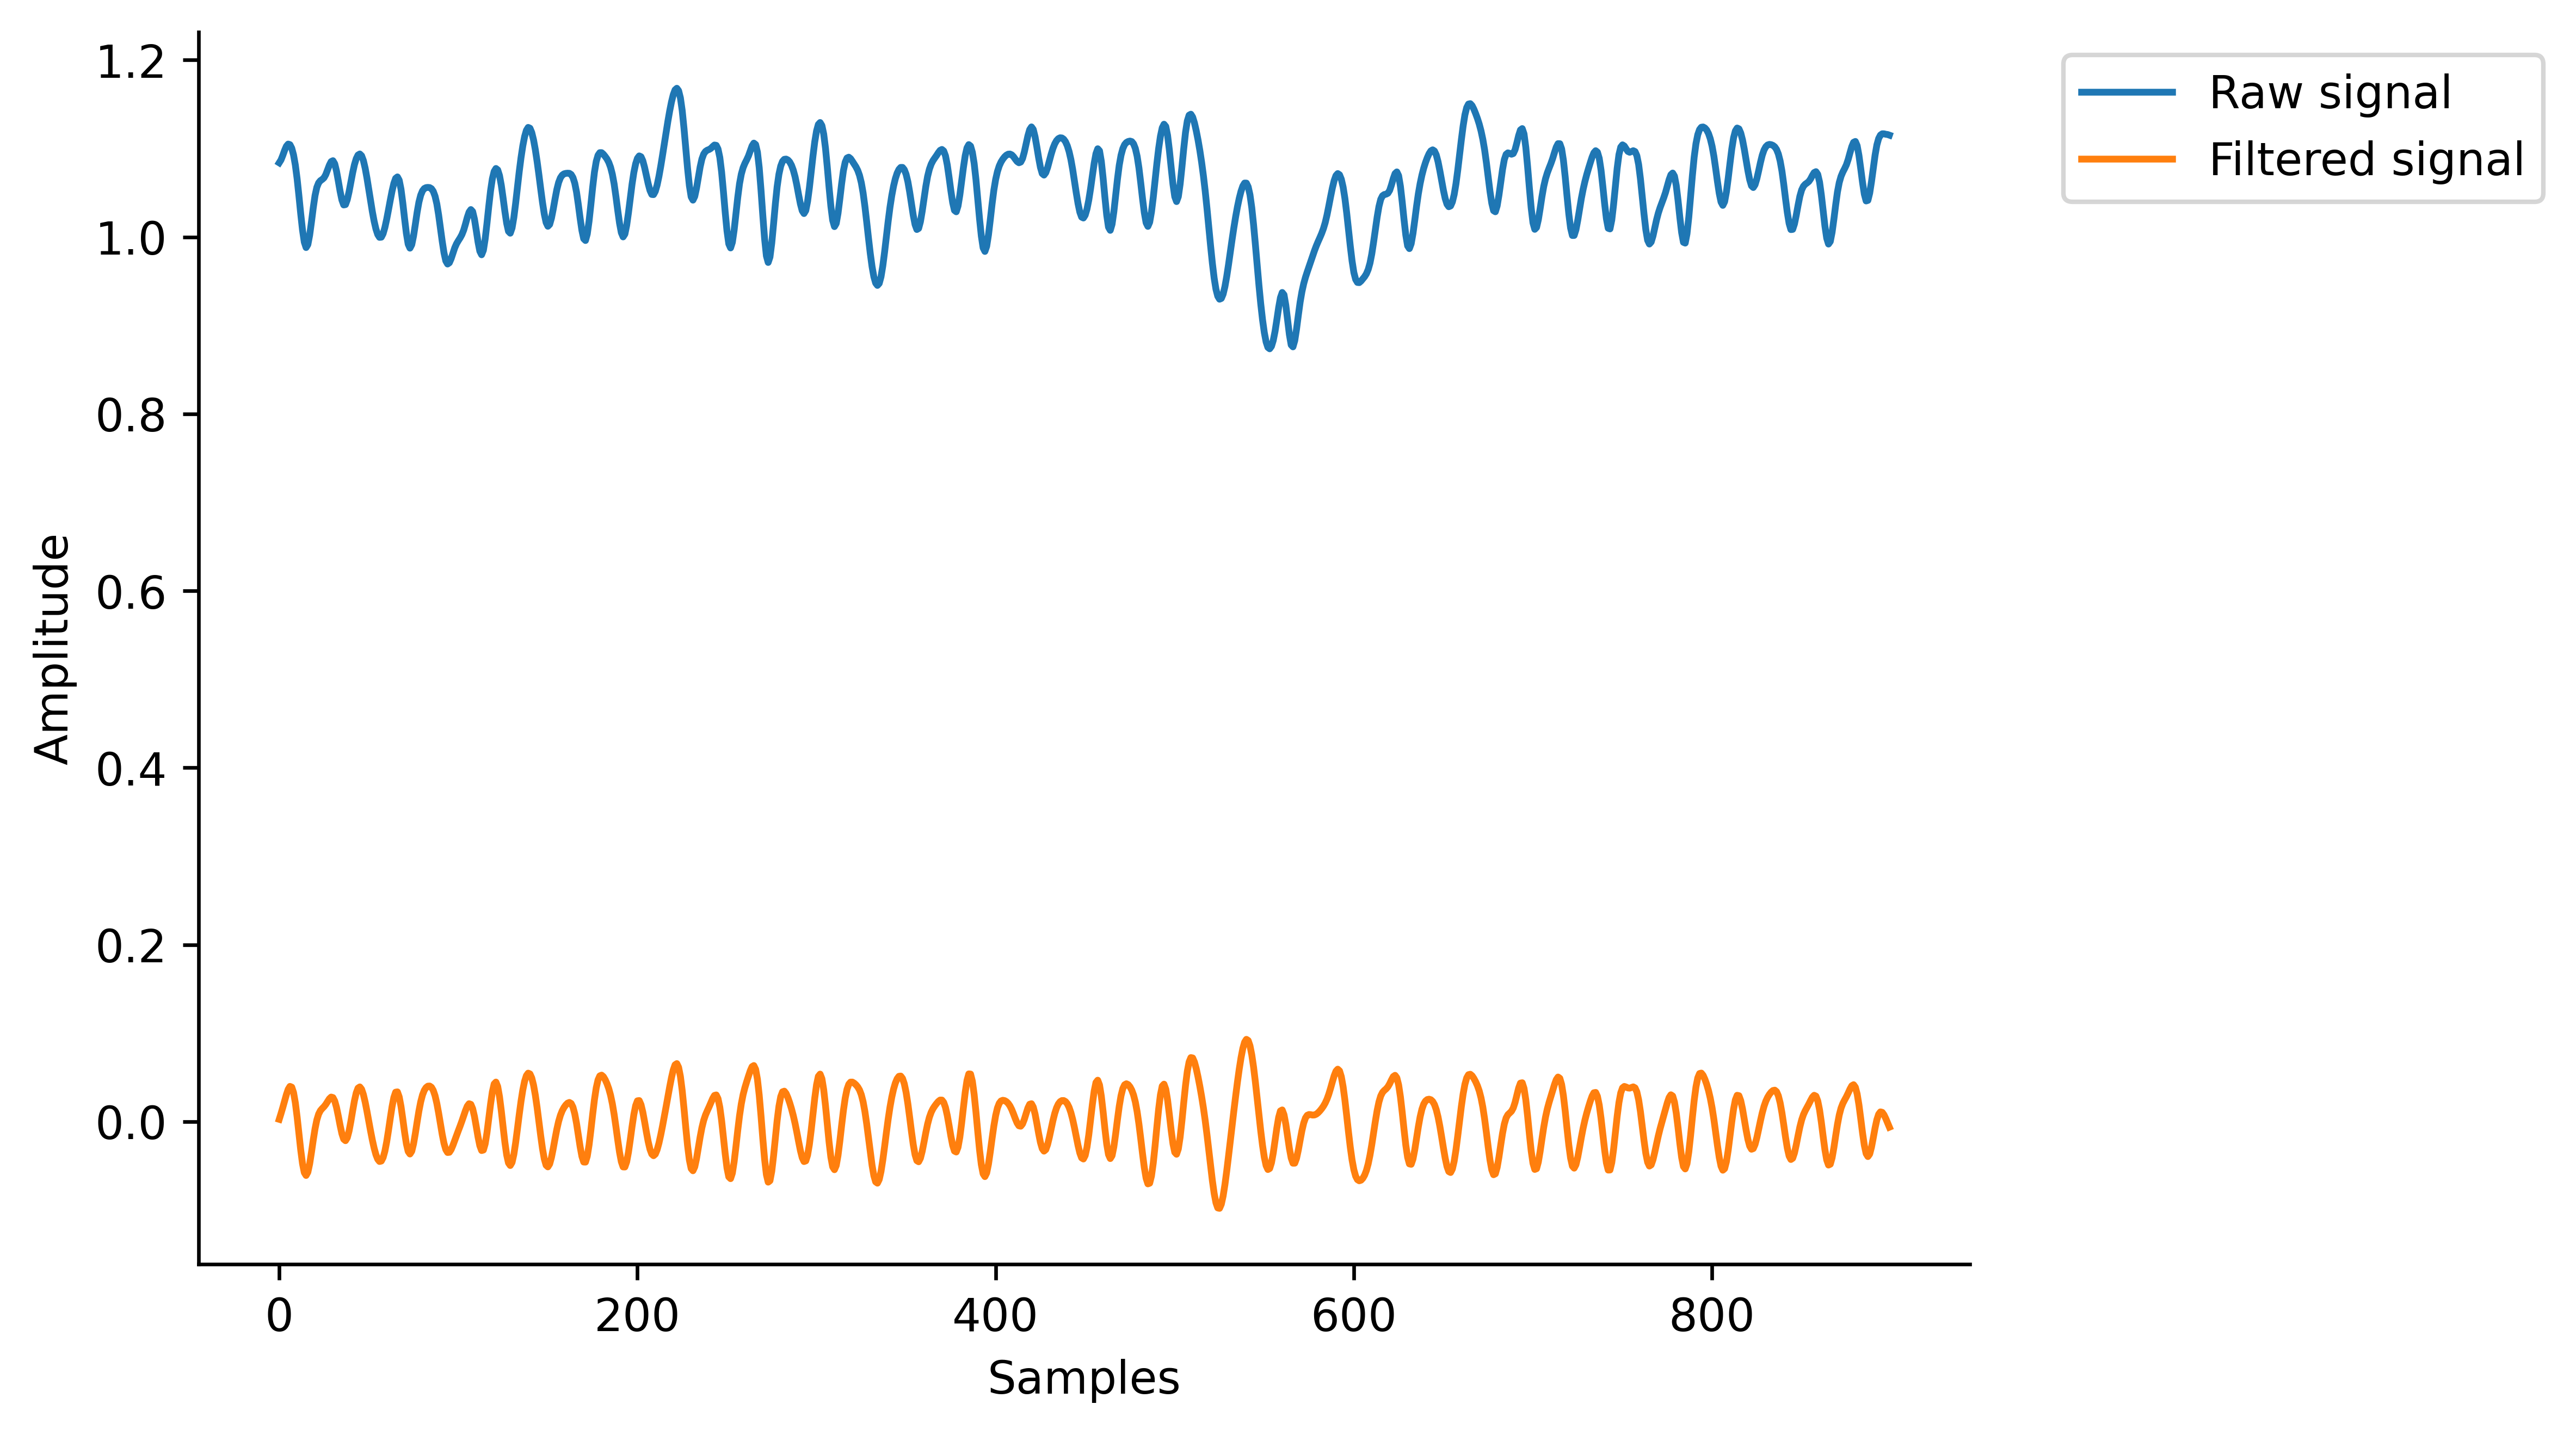

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[7,5])
plt.plot(nn, label="Raw signal")
plt.plot(nn_filtered, label="Filtered signal")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    
plt.show()

#### Original counting method (`Count-orig`)
After filtering the signal, the maxima and minima are identified. 
Then, the $Q_3$ of all the maxima is computed and a threshold of $0.2 x Q_3$
is defined. A part of the signal is considered valid if it lies between
two maxima above the threshold and contains one minimum below zero and no
other local extrema. The respiration frequency is defined as the inverse
of the length of all detected respiratory cycles.

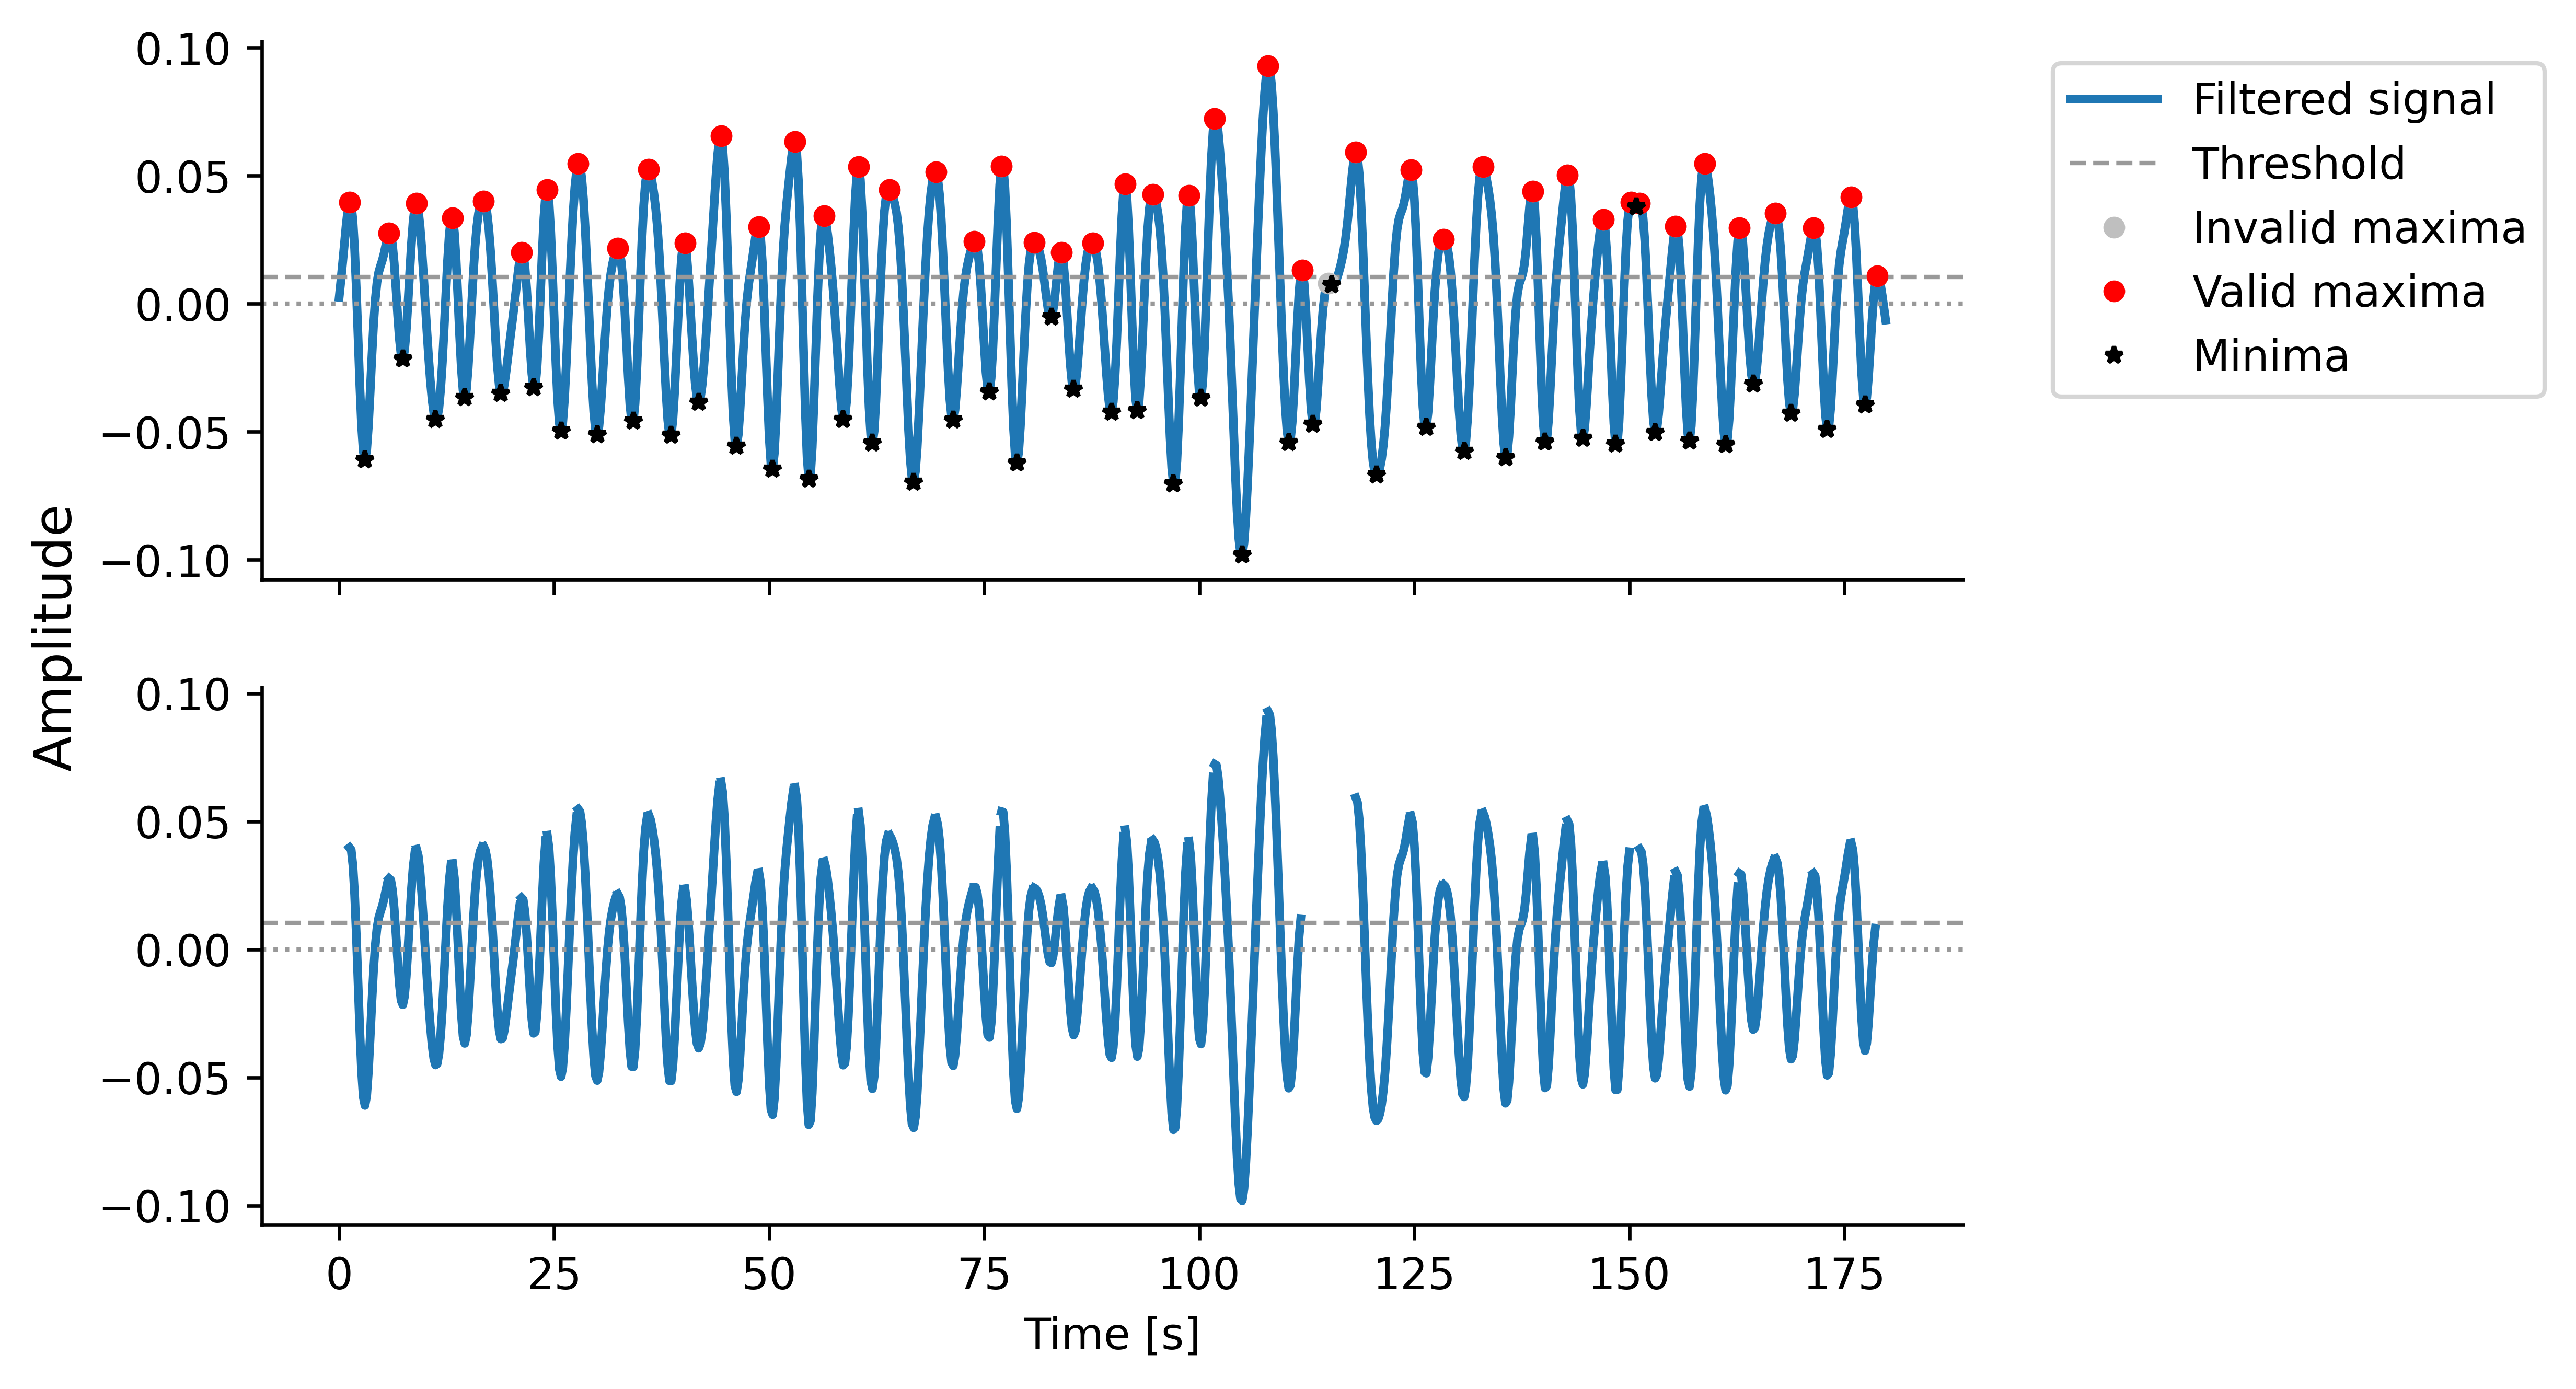

0.24647887323943662

In [12]:
breathing_rate['count_orig'], fig, ax = br.count_orig(nn, fs, f_low=0.1, f_high=0.5, visualizations=True)
breathing_rate['count_orig']

#### Advanced counting method (`Count-adv`)
Unfortunately, the `Count-orig` method ignores substantial parts of the
time series. `Count-adv` remedies this using a slightly different method.
The maxima and minima are also identified. However, in this case, 
the absolute vertical differences of subsequent extrema are calculated.
The $Q_3$ of these is computed and a threshold is defined as $0.3 x Q_3$ and $0.1 x Q_3$
for respiration and NN signals, respectively. Then, we find the pair of subsequent
extrema separated by the smallest (absolute) difference. If this value is under
the threshold, the pair is interpreted as a random fluctiation and ignored.
This is repeated until all vertical distances between subsequent extrema
are larger than the threshold, assuming that the remaining cycles are
all originated from breathing activity. Similarly as in the last case,
the respiration frequency is defined as the inverse
of the length of all detected respiratory cycles.

d:\users\artur\documents\projects\breathing-rate-rsa\src\signals\breathing_rate.py:611: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_min = np.hstack(itertools.zip_longest(maxima, minima, fillvalue=np.nan))


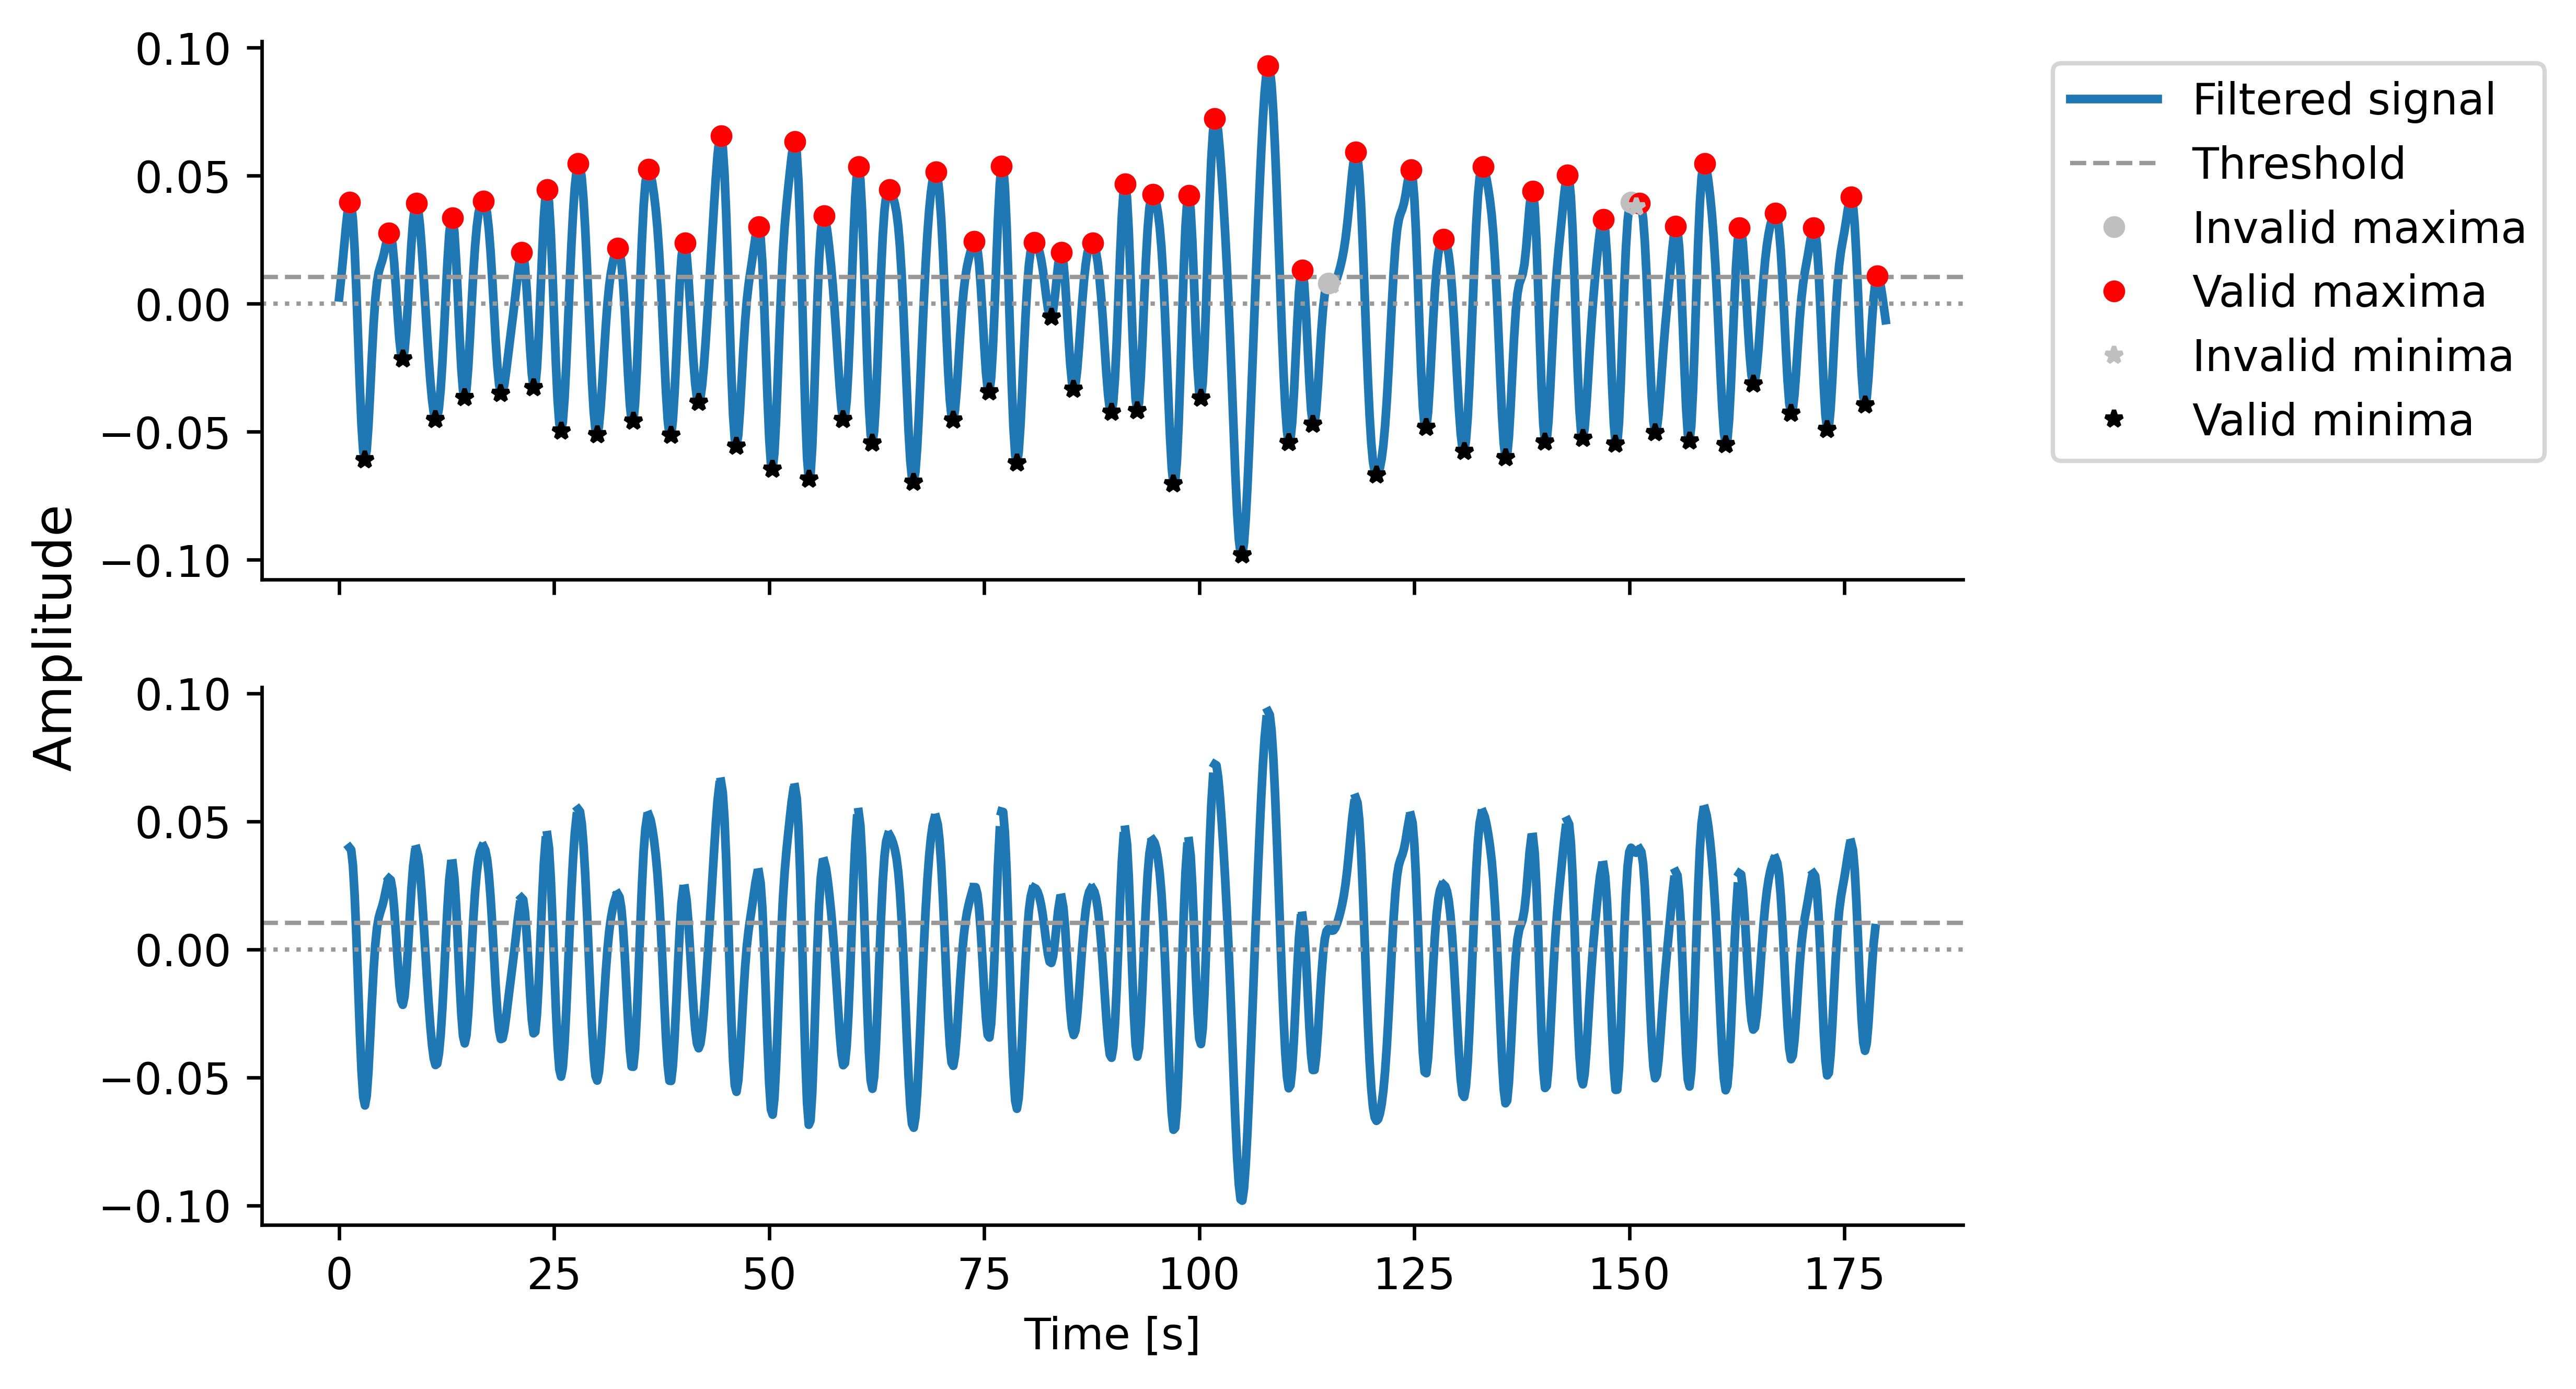

0.24211711711711711

In [13]:
breathing_rate['count_adv'], fig, ax = br.count_adv(nn, fs, f_low=0.1, f_high=0.5, signal_type='nn', visualizations=True)
breathing_rate['count_adv']